In [29]:
#importing the necessary modules
import torch
import torchvision
from torchvision import transforms,datasets
from torch.utils.data import Dataset,DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

import cv2
from skimage import io

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Data Exploration

In [30]:
#reading data
#Change path to your images and csv files path 
train_data = pd.read_csv('Train .csv')
test_data = pd.read_csv('Test .csv')
train_path = 'data/train/'
test_path = 'data/test/'

In [31]:
# train
train_names = train_data.ID.values
train_labels = np.asarray(train_data['LABEL'].values)
train_dict = {'filepath': train_path + train_names + '.png', 'LABEL': train_labels}
train = pd.DataFrame(data=train_dict)
train['ID'] = train_data['ID']
train['LABEL'] = train.LABEL.apply(lambda x: 'Positive' if x == 1 else 'Normal')

# test
test_names = test_data.ID.values
test_dict = {'filepath': test_path + test_names + '.png'}
test = pd.DataFrame(data=test_dict)
test['ID'] = test_data['ID']


In [32]:
train.head()

,filepath,LABEL,ID
0,data/train/VTYNBFTO.png,Positive,VTYNBFTO
1,data/train/GVVXXDOZ.png,Normal,GVVXXDOZ
2,data/train/PMRSQLXN.png,Normal,PMRSQLXN
3,data/train/JXISWDUU.png,Positive,JXISWDUU
4,data/train/JVWMAACC.png,Positive,JVWMAACC


In [33]:
test.head()

,filepath,ID
0,data/test/GTWSHFYQ.png,GTWSHFYQ
1,data/test/QTFSSMGD.png,QTFSSMGD
2,data/test/TBLBHSYT.png,TBLBHSYT
3,data/test/ZKETEOFG.png,ZKETEOFG
4,data/test/GKTPBGZP.png,GKTPBGZP


In [34]:
print("Train data shape is ",train.shape)
print("Test data  shape is ",test.shape)

Train data shape is  (718, 3)
Test data  shape is  (82, 2)


/home/gerald/anaconda3/envs/tb_zindi/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


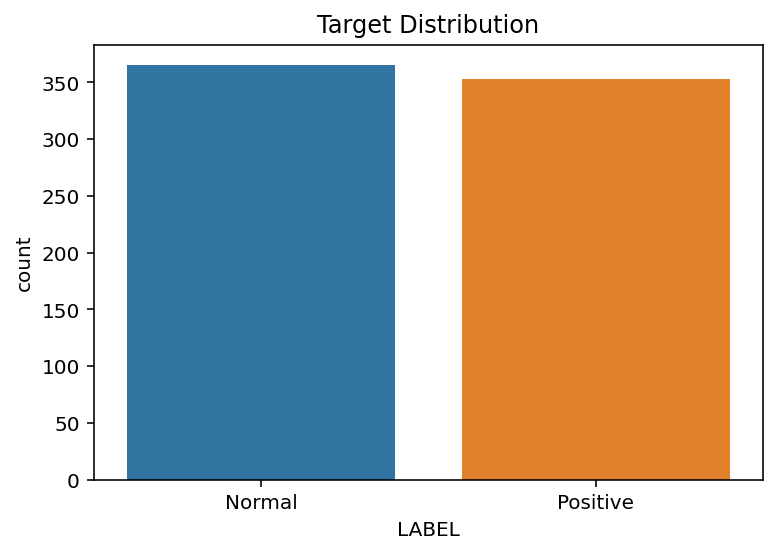

In [35]:
## EDA & PREPROCESSING
sns.countplot(train['LABEL'],order = train['LABEL'].value_counts().index)
plt.title("Target Distribution")
plt.show()

### Observation
* Our target column seems to be well balanced in the data set

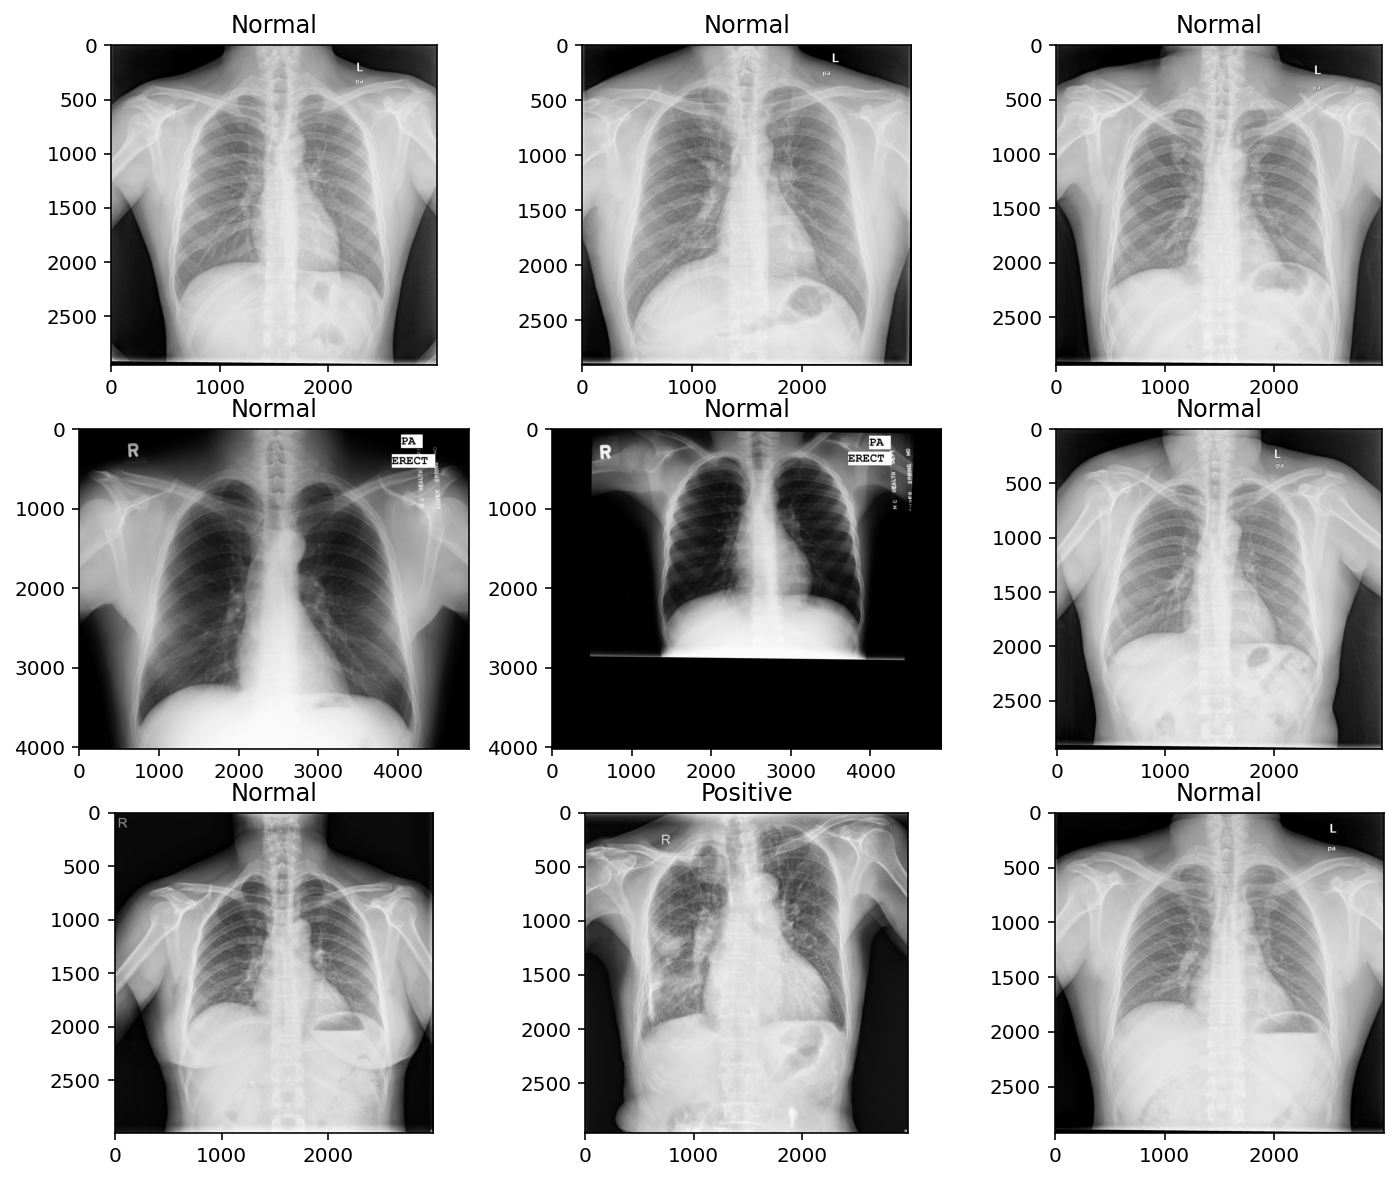

In [36]:
#Visualizing random images

#visualizing random images
nrows = 3
rands = np.random.randint(train.shape[0], size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(train.loc[rands[i], 'filepath'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train.loc[rands[i], 'LABEL'])
plt.show()

In [37]:
#creating a tranform object to convert our image to tensors
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

In [38]:
class ImageData(Dataset):
    def __init__(self,data_df,images_dir,transform = None):
        self.annotations = data_df
        self.images_dir = images_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self,index):
        img_path = os.path.join(self.images_dir,self.annotations.iloc[index,2]+".png")
        image = io.imread(img_path)
        img_label = self.annotations.iloc[index,1]
        img_dict = {'image':image,'img_label':img_label}
        
        
        if self.transform:
            image = self.transform(image)
        
        return img_dict

In [39]:
#loading our data
train_data = ImageData(data_df= train,images_dir='data/train' )

0 (4892, 4020) Positive
1 (2941, 3000) Normal
2 (2927, 3000) Normal
3 (2988, 2996) Positive


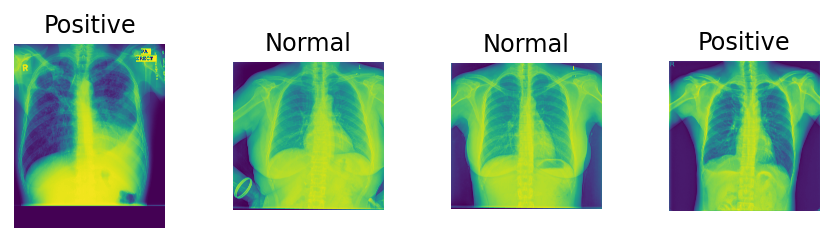

In [40]:
#visualizing our sample data
fig = plt.figure()

for i in range(len(train_data)):
    sample = train_data[i]
    print(i, sample['image'].shape, sample['img_label'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(sample['img_label'])
    ax.axis('off')
    plt.imshow(sample['image'])
    
    if i == 3:
        
        plt.show()
        break

### Observation
* Our images have different shape
* We have to standardize them

In [41]:
#function to create training and validation datasets
def split_indices(len_data,val_pct):
    #creating a list of indices of the data
    dataset_indices = list(range(len_data))
    #shuffling the list of indices
    np.random.shuffle(dataset_indices)
    #creating the split index
    val_split_index = int(np.floor(val_pct * len_data))
    return dataset_indices[val_split_index:],dataset_indices[:val_split_index]

In [42]:
train_idx,val_idx = split_indices(len(train_data),0.2)

In [43]:
#creating the samplers
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(val_idx)

In [44]:
train_loader = DataLoader(dataset=train_data,shuffle=False,batch_size = 1,sampler=train_sampler)
val_loader = DataLoader(dataset=train_data,shuffle= False,batch_size = 1,sampler=validation_sampler)

def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_loaders(train_loader, train_data)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Train Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_loaders(val_loader, train_data)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Val Set')

In [10]:
#getting our train and test data and converting it to tensors
train_data = datasets.ImageFolder('train/',transform = train_transform)
#test_data = torchvision.datasets.ImageFolder('test/',transform = test_transform)
valid_data = torchvision.datasets.ImageFolder('train/',transform = test_transform)

In [11]:
#Splitting the training data into training set and validation set
num_train = len(train_data)
indices = list(range(num_train))

#shuffling the data
np.random.shuffle(indices)

#using the SubsetRandomSampler for the split
from torch.utils.data.sampler import SubsetRandomSampler

#our validation size is 20% of training data
validation_size = 0.2
split = int(np.floor(validation_size * num_train))
train_split,val_split = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_split)
test_sampler = SubsetRandomSampler(val_split)
trainloader = torch.utils.data.DataLoader(train_data,sampler=train_sampler,batch_size = 32)
validationloader = torch.utils.data.DataLoader(valid_data,sampler=test_sampler,batch_size = 32)


In [12]:
print(trainloader.dataset.classes)

['1']


In [13]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/gerald/.cache/torch/checkpoints/resnet18-5c106cde.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Loading our dataset